In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date,timedelta

In [12]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [13]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [14]:
query = """
    select
        t1.date
        , t1.campaign_name
        , sum(t1.spend) as spend
        , t2.cohort_days
        , sum(t2.purchases) as purchases
        , sum(t2.purchase_rev) as purchase_rev 
    from
    (
        select
            date(event_timestamp) as date
            , ef.campaign_id
            , cd.campaign_name
            , sum(gross_revenue) as spend
        from venus.event_fact ef
        join venus.campaign_dimension cd 
            on ef.campaign_Id = cd.campaign_id 
            and cd.campaign_name like '%EA Mobile Direct%'
        where
            date(event_timestamp) >= '2021-02-01'
            and date(event_timestamp) <= '2021-02-28'
        group by 1,2,3
    ) t1
    left join
    (
        select
            date(install_timestamp) as install_date
            , ef.campaign_id
            , date_diff('day', install_timestamp, event_timestamp) as cohort_days
            , sum(event_count) purchases
            , sum(event_var_sum) purchase_rev
        from venus.user_event_fact ef
        join venus.campaign_dimension cd 
            on ef.campaign_Id = cd.campaign_id 
            and cd.campaign_name like '%EA Mobile Direct%'
        where
            date(install_timestamp) >= '2021-02-01'
            and date(install_timestamp) <= '2021-02-28'
            and event = 'purchase'
        group by 1,2,3
    ) t2
        on t1.date = t2.install_date
        and t1.campaign_id = t2.campaign_id
    group by 1,2,4
"""

In [15]:
cur_olympus.execute(query)
df = pd.DataFrame(cur_olympus.fetchall(), columns = [c[0] for c in cur_olympus.description])

date                                      campaign_name  \
0    2021-02-17  EA Mobile Direct - com.ea.game.starwarscapital...   
1    2021-02-17  EA Mobile Direct - com.ea.game.starwarscapital...   
2    2021-02-20  EA Mobile Direct - com.ea.game.starwarscapital...   
3    2021-02-25           EA Mobile Direct - com.ea.game.nfs14_row   
4    2021-02-19                                   EA Mobile Direct   
..          ...                                                ...   
385  2021-02-24   EA Mobile Direct - com.ea.game.simcitymobile_row   
386  2021-02-15      EA Mobile Direct - com.ea.watchface.pvzzombie   
387  2021-02-27  EA Mobile Direct - com.ea.game.starwarscapital...   
388  2021-02-27  EA Mobile Direct - com.ea.game.starwarscapital...   
389  2021-02-11           EA Mobile Direct - com.ea.game.nfs14_row   

          spend  cohort_days  purchases        purchase_rev  
0        0.0000          1.0        1.0  19.990000000000000  
1        0.0000         19.0        2.0  14.980000000000000  
2        0.0000          9.0        1.0  19.990000000000000  
3        0.0000          1.0        1.0   4.990000000000000  
4    20621.2500          NaN        NaN                None  
..          ...          ...        ...                 ...  
385      0.0000          8.0        1.0  19.990000000000000  
386      0.0000          NaN        NaN                None  
387      0.0000         10.0        1.0  19.990000000000000  
388      0.0000          1.0        1.0  19.990000000000000  
389      0.0000          NaN        NaN                None  

[390 rows x 6 columns]

In [22]:
df['purchase_rev'] = df['purchase_rev'].fillna(0).astype('float64')
df['spend'] = df['spend'].astype('float64')
df.dtypes

date              object
campaign_name     object
spend            float64
cohort_days      float64
purchases        float64
purchase_rev     float64
dtype: object

In [29]:
filters = ((df.cohort_days < 30) & (df.cohort_days >= 0)) | (df.cohort_days.isna())
i = 'campaign_name'
df[filters].pivot_table(values = ['spend','purchases','purchase_rev'], index = i, aggfunc = np.sum).sort_values(['purchase_rev','spend'], ascending = False)

purchase_rev  purchases  \
campaign_name                                                                 
EA Mobile Direct - com.ea.game.nfs14_row                 3229.50      150.0   
EA Mobile Direct - com.ea.game.starwarscapital_row       1394.62       88.0   
EA Mobile Direct - com.ea.game.simcitymobile_row         1222.90      110.0   
EA Mobile Direct  - com.ea.games.simsfreeplay_na          386.45       55.0   
EA Mobile Direct - com.ea.gp.maddennfl21mobile            217.60       40.0   
EA Mobile Direct - com.ea.gp.fifamobile                   200.85       23.0   
EA Mobile Direct                                            0.00        0.0   
EA Mobile Direct - com.ea.game.pegglex_row                  0.00        0.0   
EA Mobile Direct - com.ea.game.pvz2_na                      0.00        0.0   
EA Mobile Direct - com.ea.game.simpsons4_na                 0.00        0.0   
EA Mobile Direct - com.ea.games.r3_na                       0.00        0.0   
EA Mobile Direct - com.ea.gp.bej3                           0.00        0.0   
EA Mobile Direct - com.ea.gp.bejeweledskies                 0.00        0.0   
EA Mobile Direct - com.ea.gp.nbamobile                      0.00        0.0   
EA Mobile Direct - com.ea.gp.novanfs20                      0.00        0.0   
EA Mobile Direct - com.ea.gp.simsmobile                     0.00        0.0   
EA Mobile Direct - com.ea.gp.starwarsbfcompanion            0.00        0.0   
EA Mobile Direct - com.ea.watchface.pvzzombie               0.00        0.0   
EA Mobile Direct- com.ea.BejeweledBlitz_na                  0.00        0.0   
EA Mobile Direct- com.ea.game.easportsufc_row               0.00        0.0   
EA Mobile Direct- com.ea.game.pvzfree_row                   0.00        0.0   
EA Mobile Direct- com.ea.gp.candcwarzones                   0.00        0.0   
EA Mobile Direct- com.ea.gp.fifamobile                      0.00        0.0   
EA Mobile Direct- com.ea.gp.madden19companionapp            0.00        0.0   
EA Mobile Direct-com.bioware.android.apps.authe...          0.00        0.0   

                                                       spend  
campaign_name                                                 
EA Mobile Direct - com.ea.game.nfs14_row                 0.0  
EA Mobile Direct - com.ea.game.starwarscapital_row       0.0  
EA Mobile Direct - com.ea.game.simcitymobile_row         0.0  
EA Mobile Direct  - com.ea.games.simsfreeplay_na         0.0  
EA Mobile Direct - com.ea.gp.maddennfl21mobile           0.0  
EA Mobile Direct - com.ea.gp.fifamobile                  0.0  
EA Mobile Direct                                    266092.5  
EA Mobile Direct - com.ea.game.pegglex_row               0.0  
EA Mobile Direct - com.ea.game.pvz2_na                   0.0  
EA Mobile Direct - com.ea.game.simpsons4_na              0.0  
EA Mobile Direct - com.ea.games.r3_na                    0.0  
EA Mobile Direct - com.ea.gp.bej3                        0.0  
EA Mobile Direct - com.ea.gp.bejeweledskies              0.0  
EA Mobile Direct - com.ea.gp.nbamobile                   0.0  
EA Mobile Direct - com.ea.gp.novanfs20                   0.0  
EA Mobile Direct - com.ea.gp.simsmobile                  0.0  
EA Mobile Direct - com.ea.gp.starwarsbfcompanion         0.0  
EA Mobile Direct - com.ea.watchface.pvzzombie            0.0  
EA Mobile Direct- com.ea.BejeweledBlitz_na               0.0  
EA Mobile Direct- com.ea.game.easportsufc_row            0.0  
EA Mobile Direct- com.ea.game.pvzfree_row                0.0  
EA Mobile Direct- com.ea.gp.candcwarzones                0.0  
EA Mobile Direct- com.ea.gp.fifamobile                   0.0  
EA Mobile Direct- com.ea.gp.madden19companionapp         0.0  
EA Mobile Direct-com.bioware.android.apps.authe...       0.0

Text(0.5, 0.98, 'Cohorted purchases and revenue for installs in Feb')

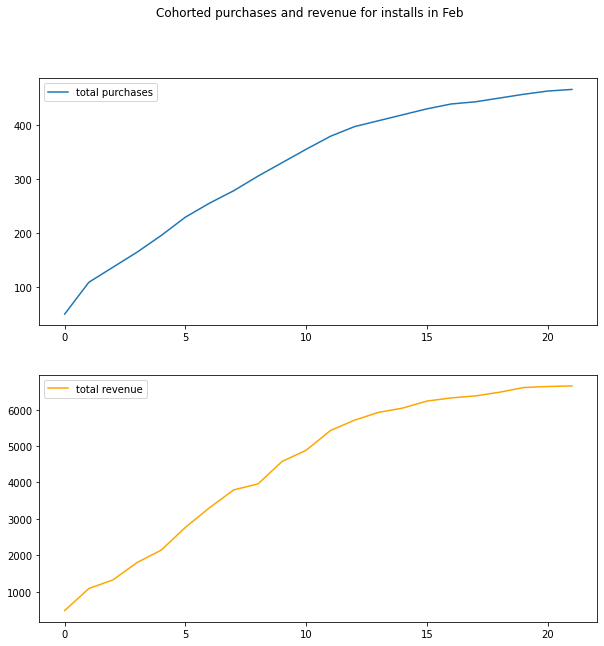

In [45]:
filters = ((df.cohort_days < 30) & (df.cohort_days >= 0)) | (df.cohort_days.isna())
i = 'cohort_days'
pivot = df[filters].pivot_table(values = ['spend','purchases','purchase_rev'], index = i, aggfunc = np.sum)
pivot['total_purchases'] = pivot['purchases'].cumsum()
pivot['total_revenue'] = pivot['purchase_rev'].cumsum()
fig, ax = plt.subplots(2,1, figsize = (10,10))
ax[0].plot(pivot['total_purchases'])
ax[1].plot(pivot['total_revenue'], color = 'orange')
ax[0].legend(['total purchases'])
ax[1].legend(['total revenue'])
fig.suptitle('Cohorted purchases and revenue for installs in Feb')

Text(0.5, 0.98, 'Cohorted revenue-per-purchase by cohorted days since install in Feb')

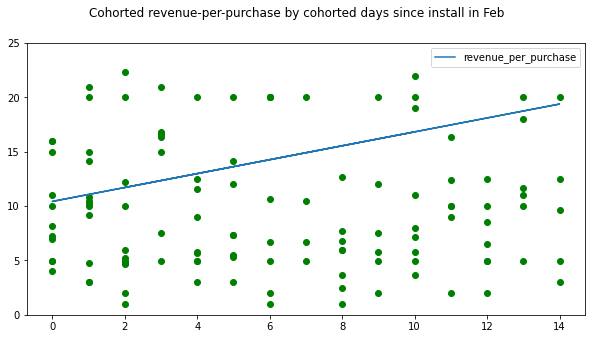

In [102]:
filters = ((df.cohort_days <= 14) & (df.cohort_days >= 0)) | (df.cohort_days.isna())
i = ['date','cohort_days']
pivot = df[filters].pivot_table(values = ['spend','purchases','purchase_rev'], index = i, aggfunc = np.sum)
pivot.reset_index(inplace = True)
pivot['revenue_per_purchase'] = pivot['purchase_rev']/pivot['purchases']
pivot.set_index('cohort_days',inplace = True)
x = pivot.index
y = pivot['revenue_per_purchase']

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.set_ylim(0,25)
ax.scatter(x, y, color = 'green')
ax.plot(x, p(x))
ax.legend(['revenue_per_purchase'])
fig.suptitle('Cohorted revenue-per-purchase by cohorted days since install in Feb')